<div align="center">
<font size="5">__Notebook for testing the reconstrcution of LST1 data.__</font>
<br><br>
<font size="4">This Notebook shows the steps followed within cta-lstchain to reconstruct event data from a corsika-simtelarray file to a dl2 data level, with reconstructed energy, direction and gamma/hadron separation.</font>
<font size="4">
To run this notebook you will need the last version of cta-lstchain:

git clone https://github.com/cta-observatory/cta-lstchain
<br>
<br>
**If you have ctapipe already installed in a conda environment:**
<br><br>
source activate cta-dev
<br>
python setup.py install
<br>
<font size="4">
**If you don't have ctapipe installed:**</font>
<br><br>
conda env create -f environment.yml
<br>
source activate cta-dev
<br>
python setup.py install

Also, you will need the datafiles from **cta-lstchain-extra:**

git clone https://github.com/misabelber/cta-lstchain-extra


<font size="4">
    **Some imports...**

In [2]:
from sklearn.externals import joblib
from ctapipe.utils import get_dataset_path
import matplotlib.pyplot as plt
import os
import pandas as pd
import lstchain.reco.dl0_to_dl1 as calib
import lstchain.reco.reco_dl1_to_dl2 as reco
import lstchain.visualization.plot_dl2 as lstplot
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14

<font size="4">
**Import a simtelarray file of MC simulated data:**

In [28]:
calib.max_events = 1000 #Limit the number of events to analyze, to speed the examples
try:
    datafile = "/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run7___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"
    calib.r0_to_dl1(datafile)
except:
    datafile = get_dataset_path('gamma_test_large.simtel.gz')
    calib.r0_to_dl1(datafile)

0
100
200
300
400


<font size="4">
**Calibration and parameters extraction**
    <br><br>
    We have a function for extracting all the image information:
    - Charge extraction
    - Cleaning
    - Hillas Parameters
    - Timing parameters

We store this information in a custom container which we write into a **hdf5** file.

In [29]:
output_filename = 'dl1_' + os.path.basename(datafile).split('.')[0] + '.h5'

<font size="4">
We can read this file as a **pandas dataframe**:

In [30]:
#Take a look at the parameters extracted from the simtelarray file:
data = pd.read_hdf(output_filename, key='events/LSTCam')
print(data.keys())

Index(['disp_angle', 'disp_dx', 'disp_dy', 'disp_miss', 'disp_norm',
       'disp_sign', 'event_id', 'gps_time', 'hadroness', 'intensity',
       'intercept', 'kurtosis', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az',
       'mc_az_tel', 'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y'],
      dtype='object')


In [31]:
data

,disp_angle,disp_dx,disp_dy,disp_miss,disp_norm,disp_sign,event_id,gps_time,hadroness,intensity,...,psi,r,skewness,src_x,src_y,time_gradient,width,wl,x,y
0,-0.133242,-0.403171,0.054040,0.381431,0.406776,-1.0,101,1.443798e+09,0,2.478154,...,1.082685,0.406776,-0.104674,0.0,0.0,-4.054393e+00,0.111438,0.864779,0.403171,-0.054040
1,1.073176,0.362960,0.668168,0.014699,0.760387,1.0,7502,1.443798e+09,0,2.076506,...,1.053844,0.760387,-0.204538,0.0,0.0,-1.445867e+01,0.071013,0.269468,-0.362960,-0.668168
2,-0.732542,0.258299,-0.232342,0.282170,0.347421,1.0,8202,1.443798e+09,0,2.950420,...,1.461162,0.347421,-3.850893,0.0,0.0,-4.319860e+00,0.171332,0.424344,-0.258299,0.232342
3,-0.659267,-0.356653,0.276381,0.083609,0.451208,-1.0,8205,1.443798e+09,0,2.864782,...,-0.472888,0.451208,0.130867,0.0,0.0,1.453563e+00,0.064281,0.372211,0.356653,-0.276381
4,0.534153,-0.294343,-0.174107,0.058486,0.341981,-1.0,9000,1.443798e+09,0,2.040046,...,0.362285,0.341981,0.454612,0.0,0.0,3.288592e+00,0.036499,0.359362,0.294343,0.174107
5,0.672282,0.392698,0.312578,0.178915,0.501913,1.0,10103,1.443798e+09,0,2.402121,...,0.307799,0.501913,-0.152591,0.0,0.0,-5.501057e+00,0.074846,0.452652,-0.392698,-0.312578
6,-0.283444,0.461940,-0.134557,0.262141,0.481139,1.0,10106,1.443798e+09,0,1.809131,...,-0.859635,0.481139,-0.099751,0.0,0.0,1.800260e+00,0.048008,0.338757,-0.461940,0.134557
7,-0.996372,-0.214662,0.331664,0.005036,0.395071,-1.0,10203,1.443798e+09,0,2.181456,...,-0.983624,0.395071,0.502257,0.0,0.0,3.032380e+00,0.059756,0.407361,0.214662,-0.331664
8,-0.953610,0.142625,-0.200974,0.061968,0.246440,1.0,12705,1.443798e+09,0,2.093003,...,-0.699427,0.246440,0.576596,0.0,0.0,7.798224e+00,0.042844,0.385622,-0.142625,0.200974
9,0.730931,-0.166263,-0.149071,0.044168,0.223306,-1.0,15207,1.443798e+09,0,2.093995,...,0.930034,0.223306,0.832516,0.0,0.0,-4.429611e-01,0.057144,0.683053,0.166263,0.149071


<font size="4">
**We can take a look at some of these features...**
    <br><br>
    **Energy**

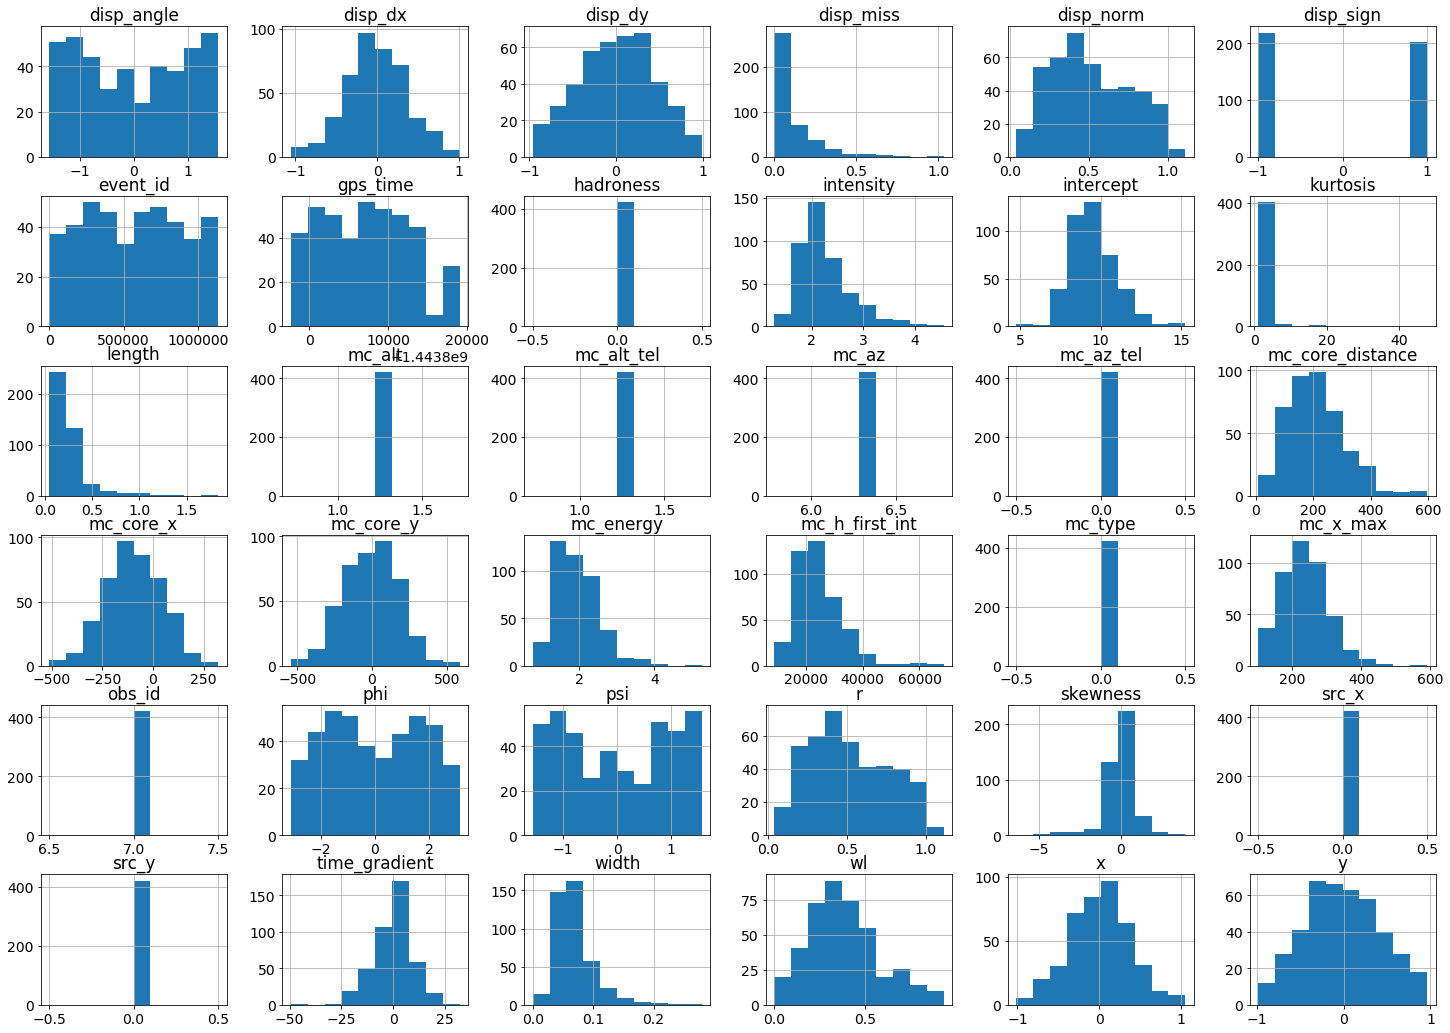

In [32]:
data.hist(figsize=(25,18));

<font size="4">
    **Source position in camera coordinates**

Text(0, 0.5, 'y (m)')

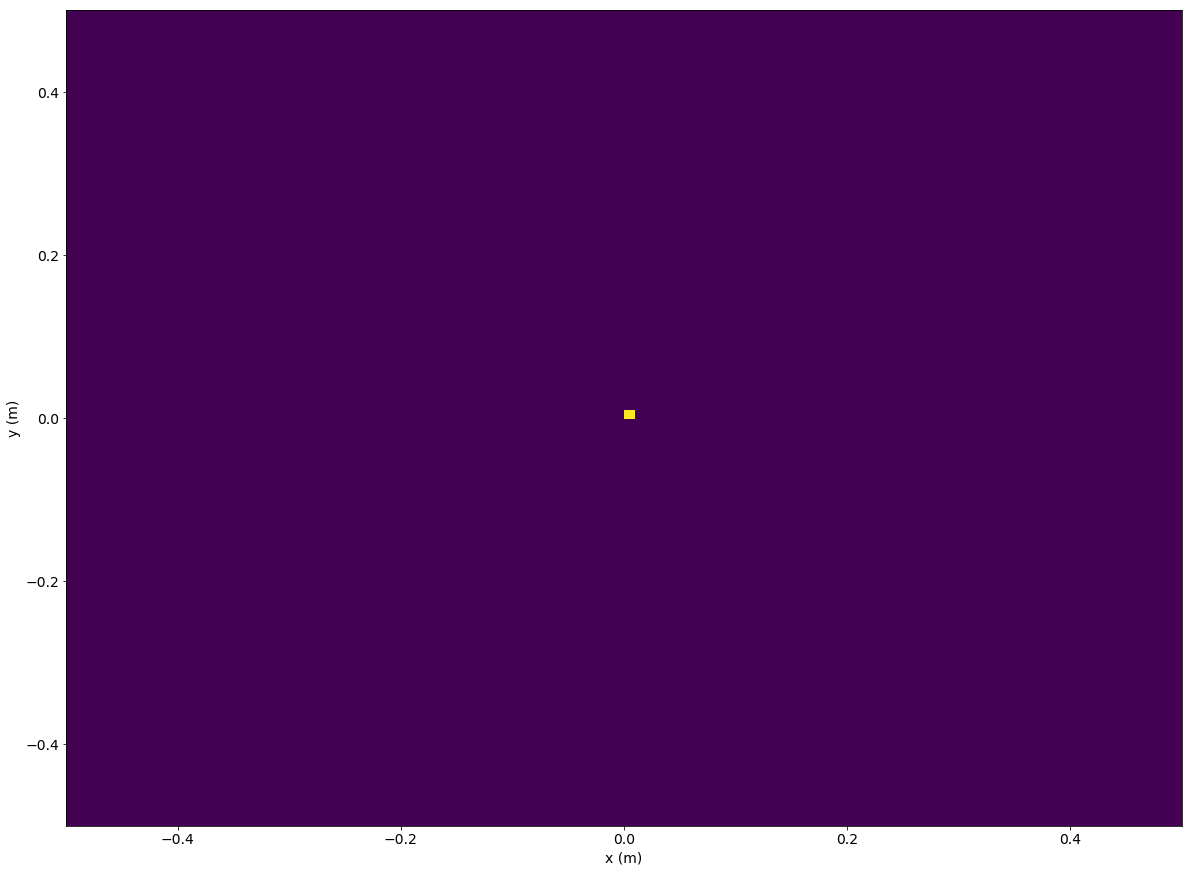

In [33]:
plt.hist2d(data['src_x'], data['src_y'], bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

<font size="4">
**Center of gravity of Hillas ellipse in camera coordinates**

Text(0, 0.5, 'y (m)')

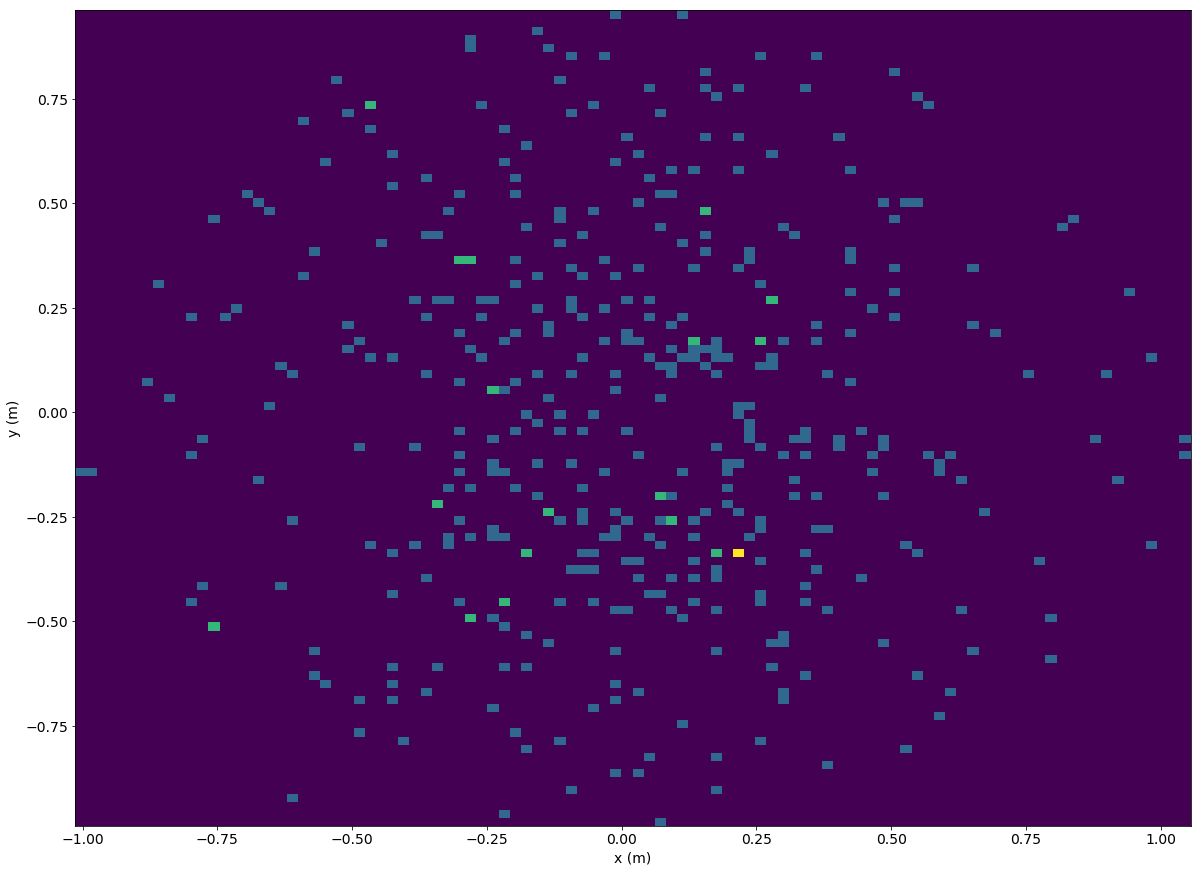

In [34]:
plt.hist2d(data['x'],data['y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

<font size="4">
**Import the Random Forests previously trained**

In [35]:
from sklearn.externals import joblib

try:
    path_models = "/home/queenmab/DATA/LST1/Models"

    fileE = path_models + "/RFreg_Energy.sav"                                                            
    fileD = path_models + "/RFreg_Disp.sav"                                                              
    fileH = path_models + "/RFcls_GH.sav"                                                                
                                                                                                              
    RFreg_Energy = joblib.load(fileE)                                                                         
    RFreg_Disp = joblib.load(fileD)                                                                           
    RFcls_GH = joblib.load(fileH)
except:
    path_models = "../../cta-lstchain-extra/reco/models"
    
    fileE = path_models + "/RFreg_Energy.sav"                                                            
    fileD = path_models + "/RFreg_Disp.sav"                                                              
    fileH = path_models + "/RFcls_GH.sav"                                                                
                                                                                                              
    RFreg_Energy = joblib.load(fileE)                                                                         
    RFreg_Disp = joblib.load(fileD)                                                                           
    RFcls_GH = joblib.load(fileH)

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Random

<font size="4">
**Features for prediction:**

In [36]:
#Define the features to train the RF:
features = ['intensity',                                                                                  
                'time_gradient',                                                                              
                'width',                                                                                      
                'length',                                                                                     
                'wl',                                                                                        
                'phi',                                                                                        
                'psi']

<font size="4">
Now we can apply the Random Forests to the data and reconsctruct the energy, direction and Gamma/Hadron classification

In [37]:
#Now we have the trained RF that we can use to reconstruct our data into dl2 format:
data_dl2 = reco.ApplyModels(data,features,RFcls_GH,RFreg_Energy,RFreg_Disp)
print(data_dl2.keys())

Index(['disp_angle', 'disp_dx', 'disp_dy', 'disp_miss', 'disp_norm',
       'disp_sign', 'event_id', 'gps_time', 'hadroness', 'intensity',
       'intercept', 'kurtosis', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az',
       'mc_az_tel', 'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y',
       'e_rec', 'disp_rec', 'src_x_rec', 'src_y_rec', 'hadro_rec'],
      dtype='object')


<font size="4">
**Plot the results**
    <br><br>
    
**Features:**
<br><br>
Since we were using a file only with gamma events, here we can notice the events that has been badly classified as protons.    

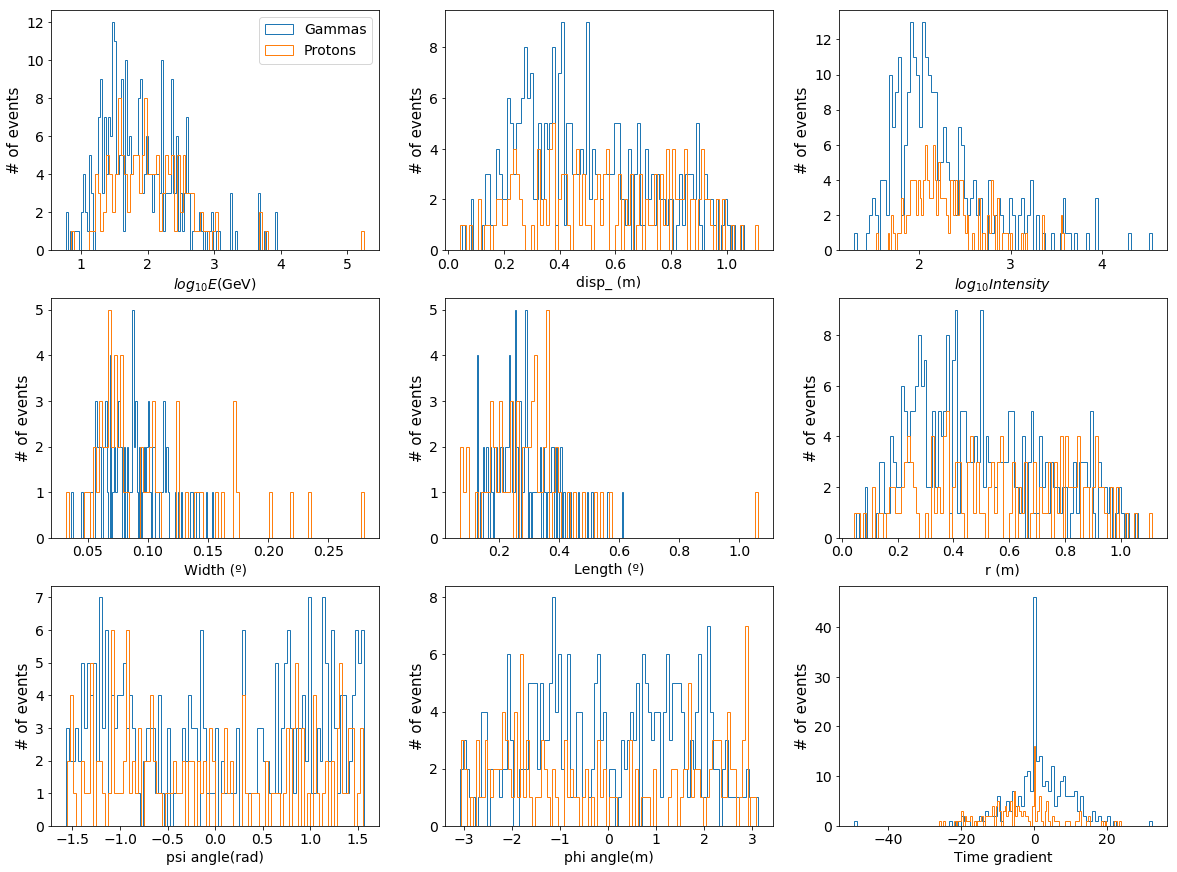

In [38]:
#Lets take a look to the results
lstplot.plot_features(data_dl2)

<font size="4">
**Energy reconstruction**

-0.019956433372248786 0.6616183513784523


/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


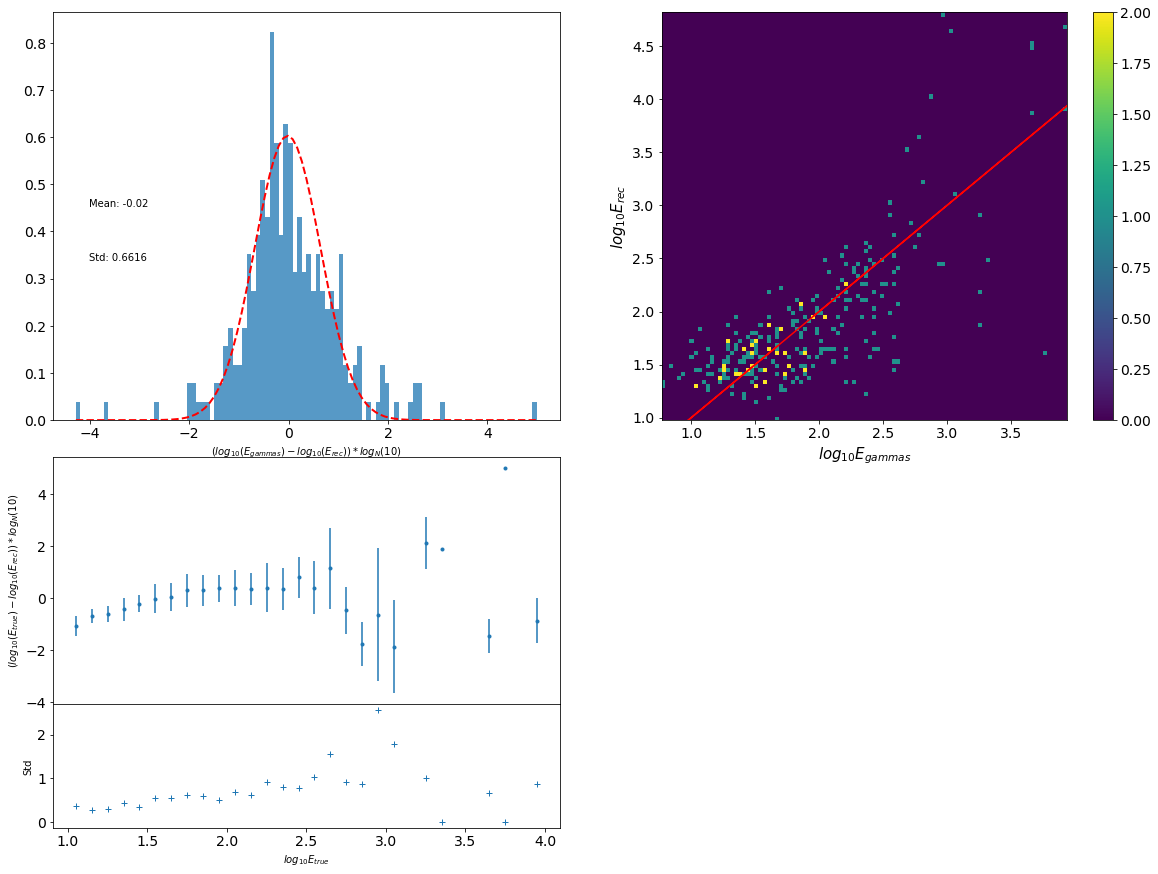

In [39]:
lstplot.plot_e(data_dl2)

<font size="4">
**Disp reconstruction**

0.09646422827952351 0.2518155175549221


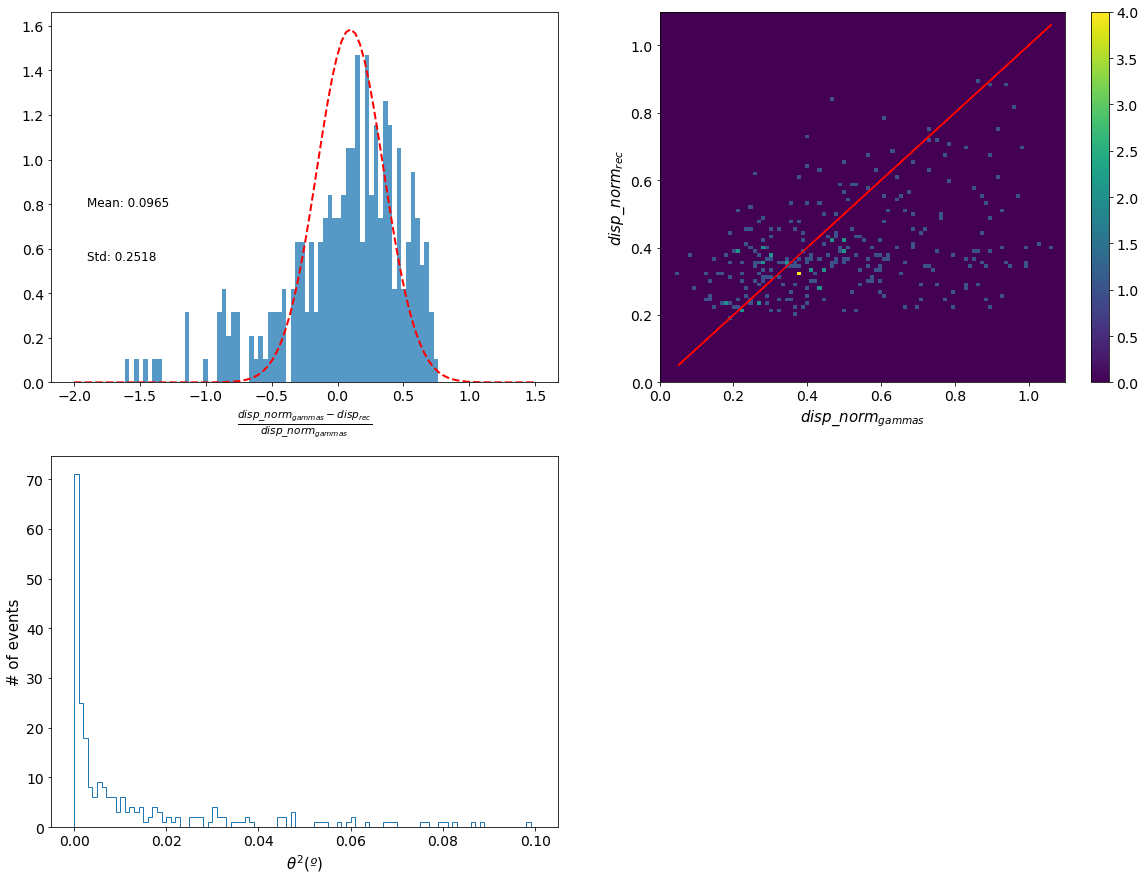

In [40]:
lstplot.plot_disp(data_dl2)

<font size="4">
**Reconstructed source position in camera coordinates**

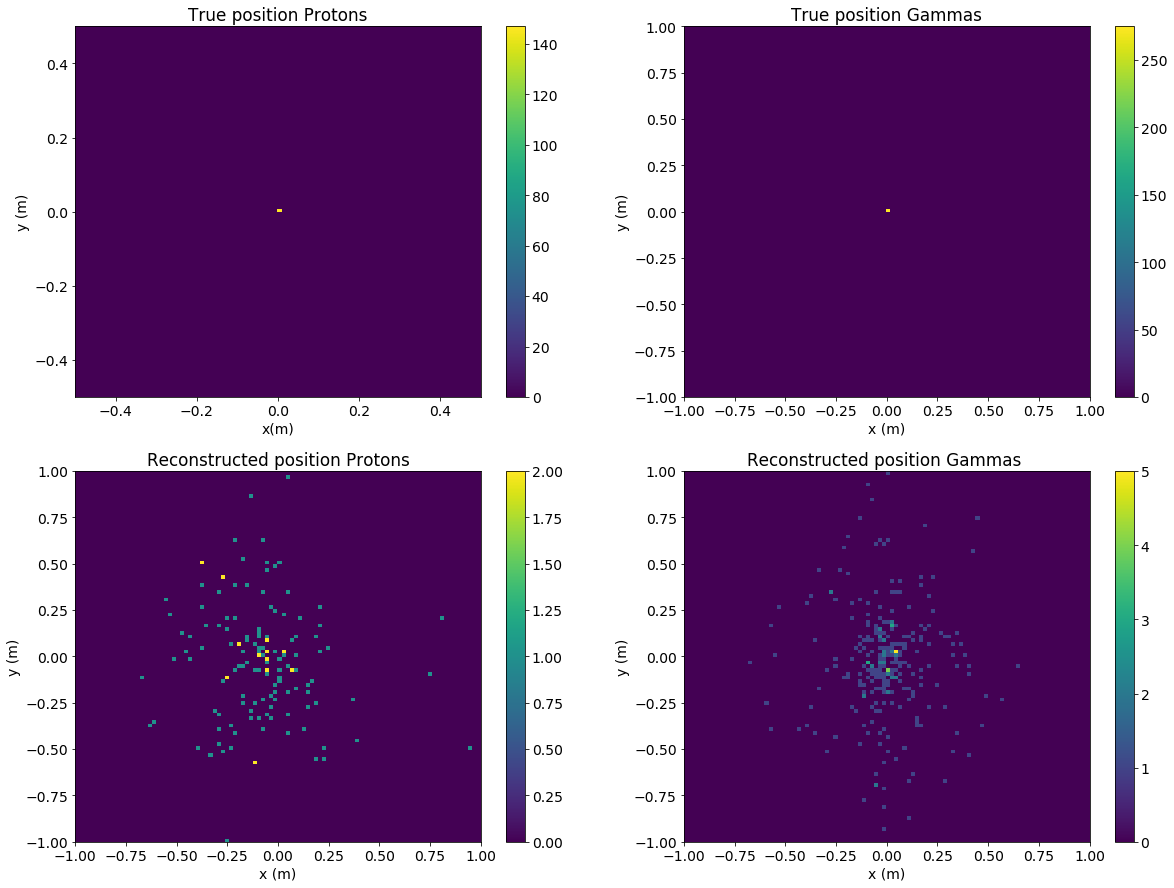

In [41]:
lstplot.plot_pos(data_dl2)

<font size="4">
**RHadroness**

Text(0.5, 0, 'Hadroness')

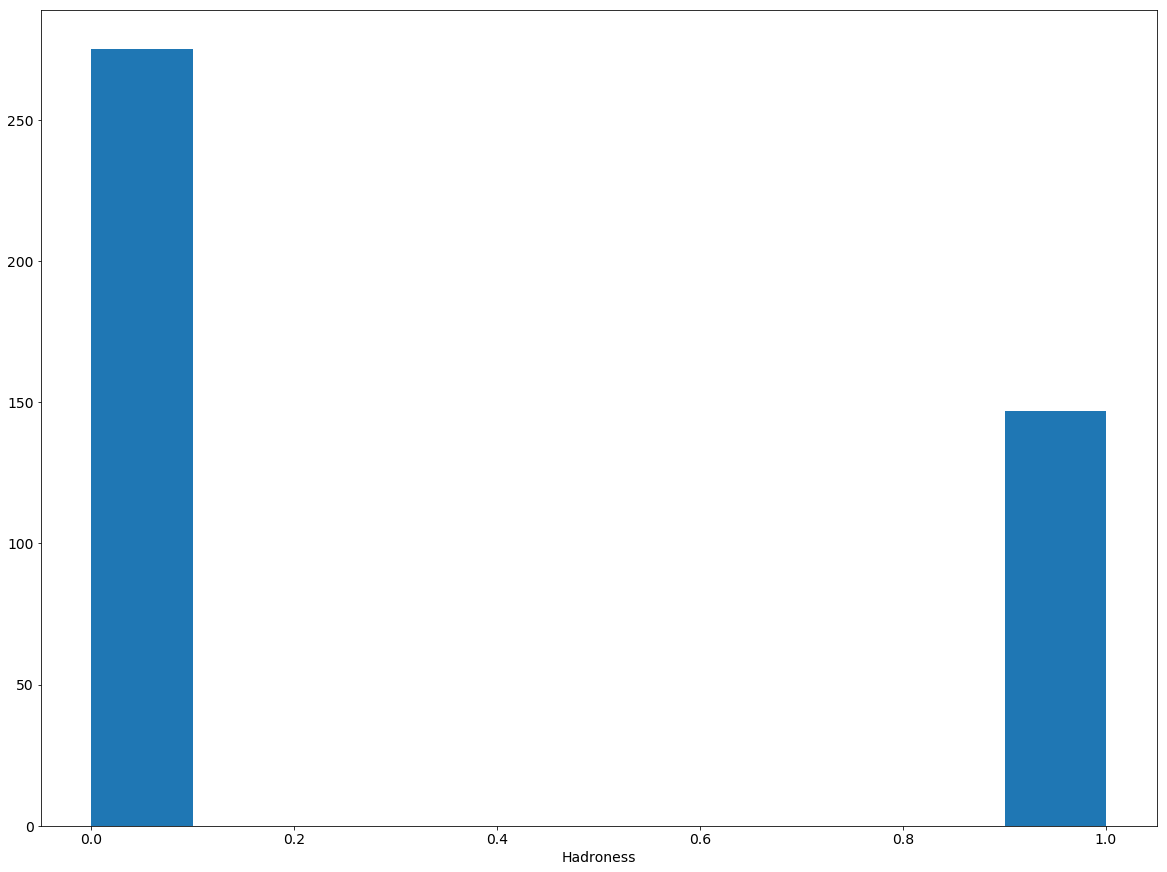

In [42]:
plt.hist(data_dl2['hadro_rec'])
plt.xlabel('Hadroness')